# Bharatanatyam Mudra Classification

### Import Libraries

In [18]:
import time
import torch
import numpy as np
import torch.backends
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix

from mudra_model import CNN

### Define the Device

In [19]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

### Define the Image Transform Object

In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),                  # Resize images to 224x224
    transforms.Grayscale(num_output_channels=1),    # Convert images to grayscale
    transforms.ToTensor(),                          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485], std=[0.229]) # Normalize images (single channel)
])

### Load the Dataset

In [21]:
dataset = datasets.ImageFolder(root='mudra_data', transform=transform)

# Split the dataset
train_size = int(0.8 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Train size: {train_size}, Validation size: {valid_size}, Test size: {test_size}")

Train size: 22744, Validation size: 2843, Test size: 2844


### Define the Model

In [22]:
# Initialize the model
model = CNN().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

### Define the Training Loop

In [6]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            data_loader = train_loader if phase == 'train' else valid_loader
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.float() / len(data_loader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # Save the model's state dictionary
    torch.save(model.state_dict(), 'mudra_model.pth')

# Train the model
train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 8.8159 Acc: 0.1740
val Loss: 2.3543 Acc: 0.3820

Epoch 2/10
----------
train Loss: 1.8455 Acc: 0.5260
val Loss: 1.0422 Acc: 0.7179

Epoch 3/10
----------
train Loss: 0.5809 Acc: 0.8359
val Loss: 0.4549 Acc: 0.8818

Epoch 4/10
----------
train Loss: 0.1752 Acc: 0.9516
val Loss: 0.3279 Acc: 0.9304

Epoch 5/10
----------
train Loss: 0.0680 Acc: 0.9803
val Loss: 0.3020 Acc: 0.9448

Epoch 6/10
----------
train Loss: 0.0304 Acc: 0.9921
val Loss: 0.2928 Acc: 0.9504

Epoch 7/10
----------
train Loss: 0.0243 Acc: 0.9940
val Loss: 0.3144 Acc: 0.9462

Epoch 8/10
----------
train Loss: 0.0224 Acc: 0.9945
val Loss: 0.3358 Acc: 0.9441

Epoch 9/10
----------
train Loss: 0.0192 Acc: 0.9949
val Loss: 0.3178 Acc: 0.9501

Epoch 10/10
----------
train Loss: 0.0149 Acc: 0.9968
val Loss: 0.3358 Acc: 0.9486

Training complete in 44m 57s
Best val Acc: 0.950405


### Evaluate the Model

In [23]:
# Load the model
model = CNN().to(device)
model.load_state_dict(torch.load('mudra_model.pth'))
model.eval()

true_labels = []
predicted_labels = []

# Make predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Store predictions and true labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Calculate metrics
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        58
           1       1.00      0.98      0.99        53
           2       1.00      0.98      0.99        81
           3       0.98      0.96      0.97        50
           4       0.93      1.00      0.96        52
           5       1.00      1.00      1.00        54
           6       0.96      1.00      0.98        51
           7       1.00      1.00      1.00        73
           8       0.97      0.97      0.97        40
           9       1.00      1.00      1.00        47
          10       1.00      1.00      1.00        78
          11       0.98      0.97      0.98        62
          12       0.93      1.00      0.97        57
          13       1.00      1.00      1.00        51
          14       0.98      1.00      0.99        49
          15       0.98      1.00      0.99        63
          16       1.00      1.00      1.00        53
          17       0.98    

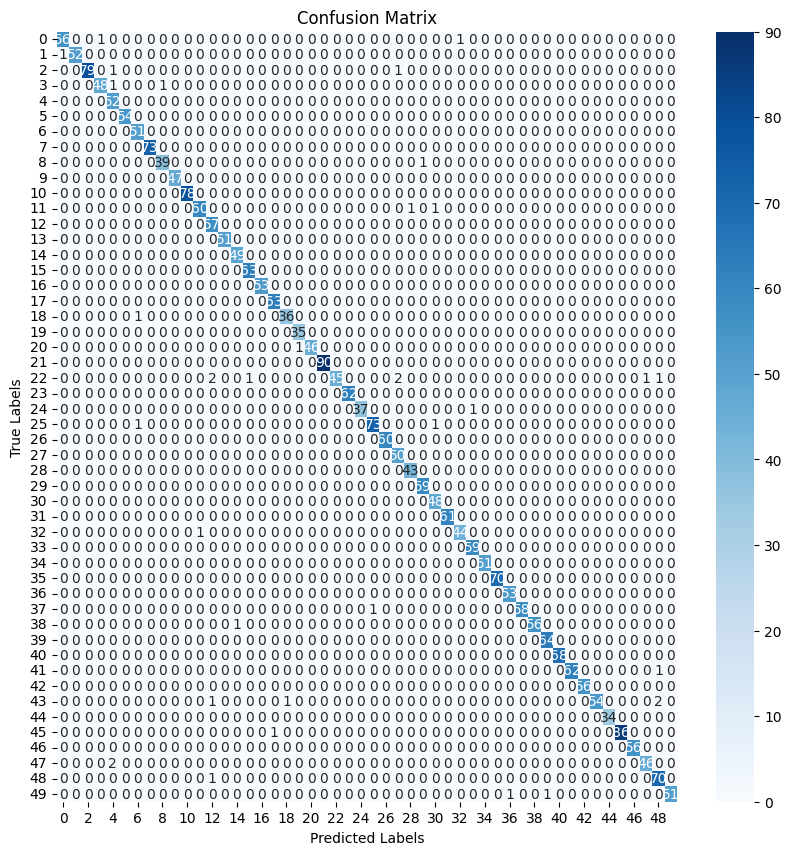

In [24]:
# Generate and visualize confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()